In [41]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

tfk = tf.keras
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
def powerlaw(x, slope, lo, hi):
    
    return (
        (x >= lo) * (x <= hi)
        * x**slope
        * (slope+1) / (hi**(slope+1) - lo**(slope+1))
        )

def sample_powerlaw(n_samples, slope, lo, hi):
    
    x = np.random.uniform(size=n_samples)
    
    return (lo**(slope+1) + x * (hi**(slope+1) - lo**(slope+1)))**(1/(slope+1))

In [3]:
from scipy.stats import beta as beta_dist, truncnorm

In [4]:
class Population:
    
    def __init__(
        self, m_min=5., m_max=50., q_min=0., q_max=1.,
        chi_mu=.5, chi_var=.05,
        cos_mean=1., cos_min=-1., cos_max=1., cos_mix=.5,
        ):
        
        self.m_min = m_min
        self.m_max = m_max
        
        self.q_min = q_min
        self.q_max = q_max
        
        self.chi_alpha = chi_mu * (chi_mu * (1 - chi_mu) / chi_var - 1)
        self.chi_beta = (1 - chi_mu) * (chi_mu * (1 - chi_mu) / chi_var - 1)
        
        self.cos_mean = cos_mean
        self.cos_min = cos_min
        self.cos_max = cos_max
        self.cos_mix = cos_mix
        
    def pdf(self, m1, q, chi1, chi2, cos1, cos2, alpha, beta, sigma1, sigma2):
        
        p_m1 = self._pdf_m1(m1, alpha)
        p_q = self._pdf_q(q, beta)
        
        p_chi1 = self._pdf_chi(chi1)
        p_chi2 = self._pdf_chi(chi2)
        
        p_ali = self._pdf_ali(chi1, sigma1) * self._pdf_ali(chi2, sigma2)
        p_iso = self._pdf_iso(chi1) * self._pdf_iso(chi2)
        p_cos = self.cos_mix * p_ali + (1. - self.cos_mix) * p_iso
        
        return p_m1 * p_q * p_chi1 * p_chi2 * p_cos
    
    def sample(self, n, alpha, beta, sigma1, sigma2):
        
        m1 = self._sample_m1(n, alpha)
        q = self._sample_q(n, beta)
        
        chi1 = self._sample_chi(n)
        chi2 = self._sample_chi(n)
        
        n_ali = int(self.cos_mix * n)
        n_iso = n - n_ali
        
        ali1 = self._sample_ali(n_ali, sigma1)
        ali2 = self._sample_ali(n_ali, sigma2)
        iso1 = self._sample_iso(n_iso)
        iso2 = self._sample_iso(n_iso)
        cos1 = np.concatenate([ali1, iso1])
        cos2 = np.concatenate([ali2, iso2])
        
        shuffle = np.arange(n)
        np.random.shuffle(shuffle)
        cos1 = cos1[shuffle]
        cos2 = cos2[shuffle]
        
        return np.array([m1, q, chi1, chi2, cos1, cos2])
        
    def _get_truncnorm_pars(self, sigma):
        
        a = (self.cos_min - self.cos_mean) / sigma
        b = (self.cos_max - self.cos_mean) / sigma
        
        return a, b
    
    def _pdf_m1(self, m1, alpha):
        
        return powerlaw(m1, alpha, self.m_min, self.m_max)
    
    def _pdf_q(self, q, beta):
        
        return powerlaw(q, beta, self.q_min, self.q_max)
    
    def _pdf_chi(self, chi):
        
        return beta_dist.pdf(chi, self.chi_alpha, self.chi_beta)
    
    def _pdf_ali(self, cos, sigma):
        
        return truncnorm.pdf(
            cos, *self._get_truncnorm_pars(sigma), self.cos_mean, sigma,
            )
    
    def _pdf_iso(self, cos):
        
        return powerlaw(cos, 0., self.cos_min, self.cos_max)
    
    def _pdf_cos(self, cos, sigma):
        
        p_ali = self._pdf_ali(cos, sigma)
        p_iso = self._pdf_iso(cos)
        
        return self.cos_mix * p_ali + (1. - self.cos_mix) * p_iso
    
    def _sample_m1(self, n, alpha):
        
        return sample_powerlaw(n, alpha, self.m_min, self.m_max)
    
    def _sample_q(self, n, beta):
        
        return sample_powerlaw(n, beta, self.q_min, self.q_max)
    
    def _sample_chi(self, n):
        
        return beta_dist.rvs(self.chi_alpha, self.chi_beta, size=n)
    
    def _sample_ali(self, n, sigma):
        
        return truncnorm.rvs(
            *self._get_truncnorm_pars(sigma), self.cos_mean, sigma, size=n,
            )
    
    def _sample_iso(self, n):
        
        return sample_powerlaw(n, 0., self.cos_min, self.cos_max)

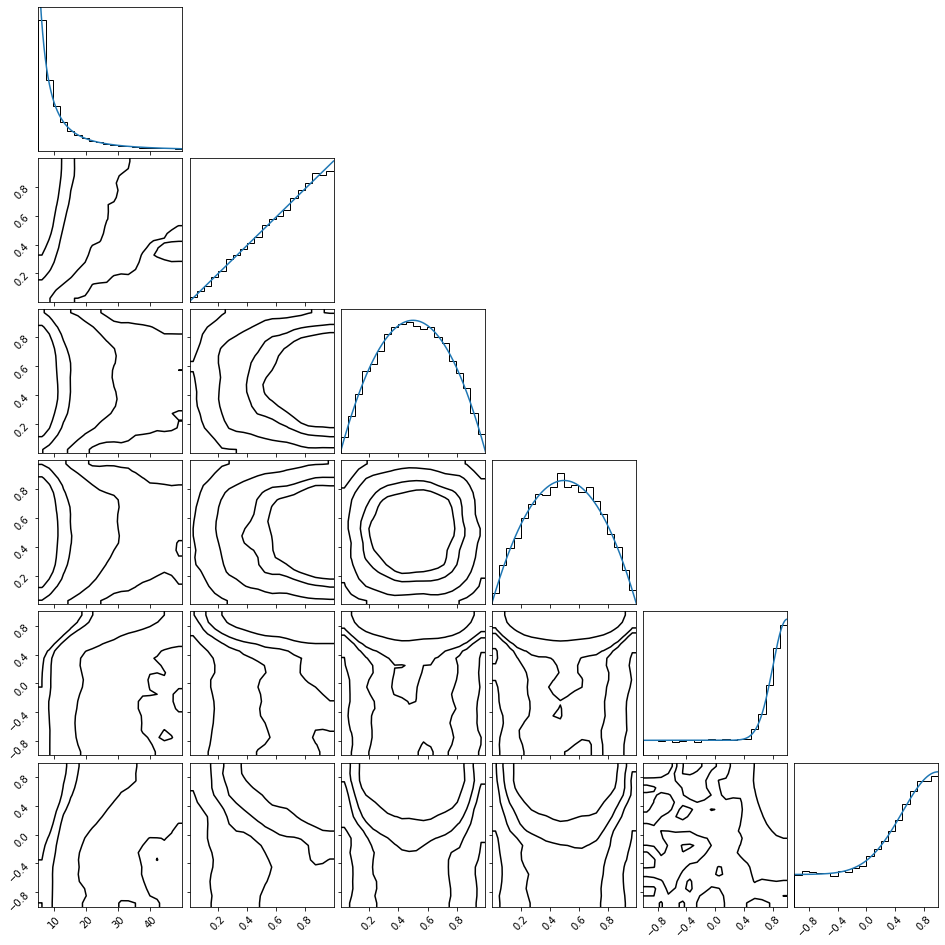

In [20]:
n = 10000
alpha = -2
beta = 1
sigma1 = .2
sigma2 = .5

pop = Population()

fig = corner(
    pop.sample(n, alpha, beta, sigma1, sigma2).T,
    plot_datapoints=False, plot_density=False,
    levels=[.5, .68, .9, .99], smooth=1,
    hist_kwargs=dict(density=True),
    )

axes = np.reshape(fig.axes, [6, 6])

m1 = np.linspace(5., 50., 1000)
axes[0, 0].plot(m1, pop._pdf_m1(m1, alpha))

q = np.linspace(0., 1., 1000)
axes[1, 1].plot(q, pop._pdf_q(q, beta))

chi = np.linspace(0., 1., 1000)
for i in [2, 3]:
    axes[i, i].plot(chi, pop._pdf_chi(chi))
    
cos = np.linspace(-1., 1., 1000)
for i in [1, 2]:
    axes[3+i, 3+i].plot(cos, pop._pdf_cos(cos, eval(f'sigma{i}')))

In [39]:
n_pars = 10
n_samples = 10000

alpha = np.random.uniform(-3, -1, n)
beta = np.random.uniform(1, 3, n)
sigma1 = np.random.uniform(0, 2, n)
sigma2 = np.random.uniform(0, 2, n)
pars = np.transpose([alpha, beta, sigma1, sigma2])

samples = []
for par in pars:
    samples.append(pop.sample(n_samples, *par).T)
samples = np.array(samples)

samples.shape

(10, 10000, 6)

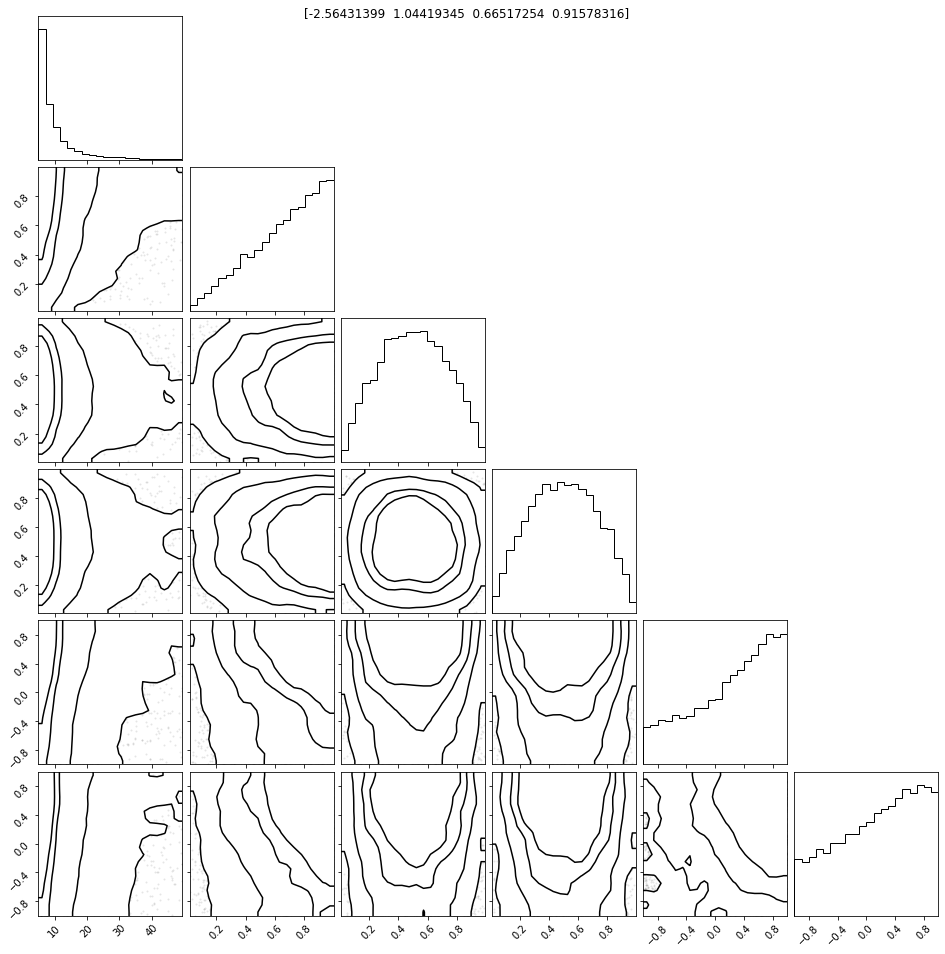

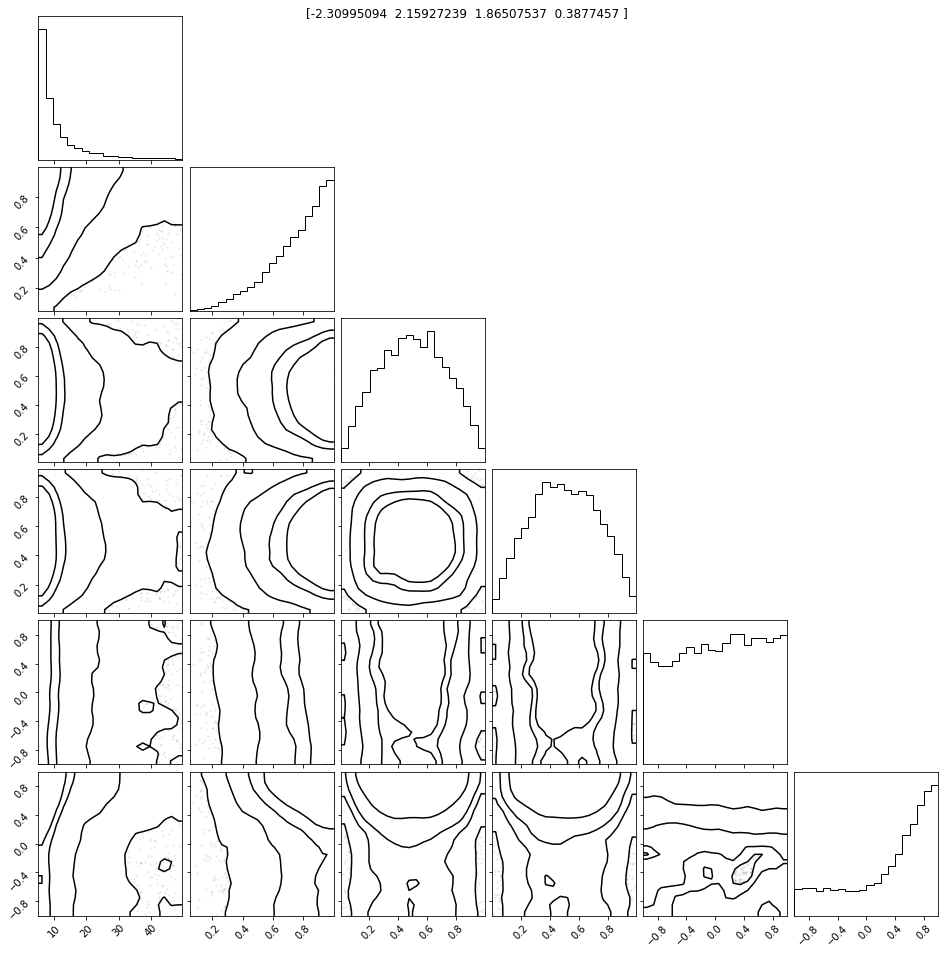

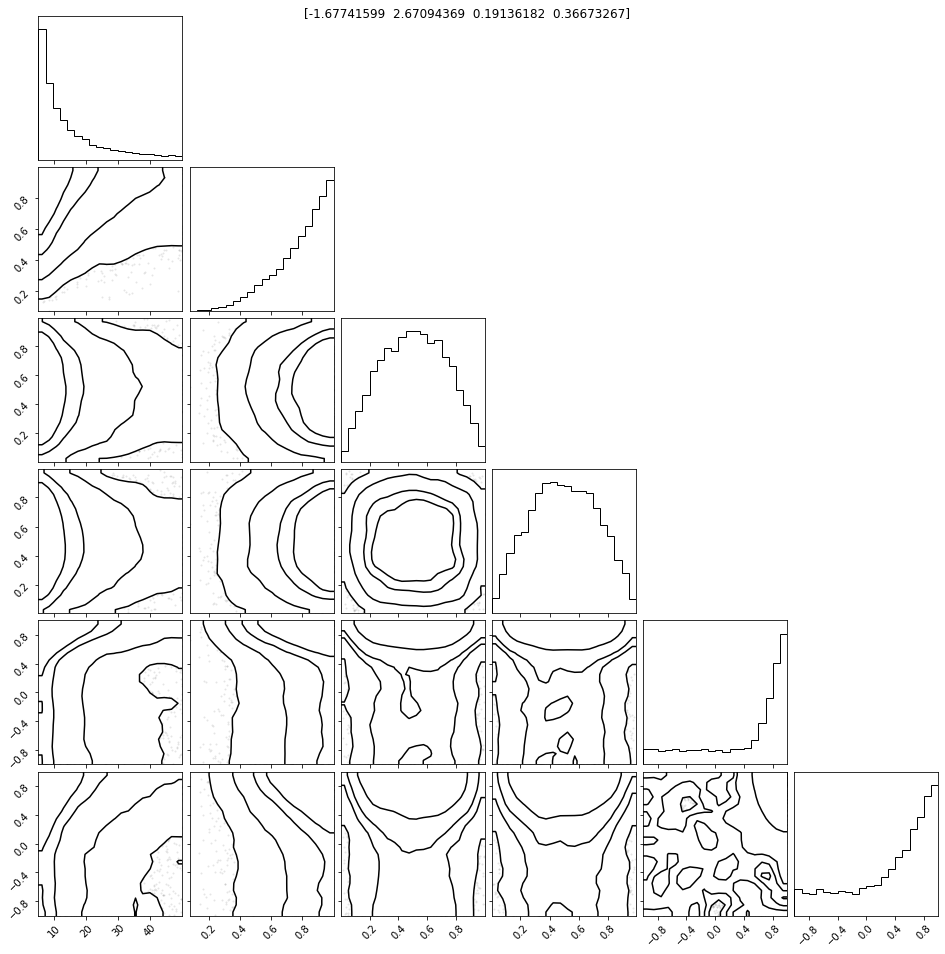

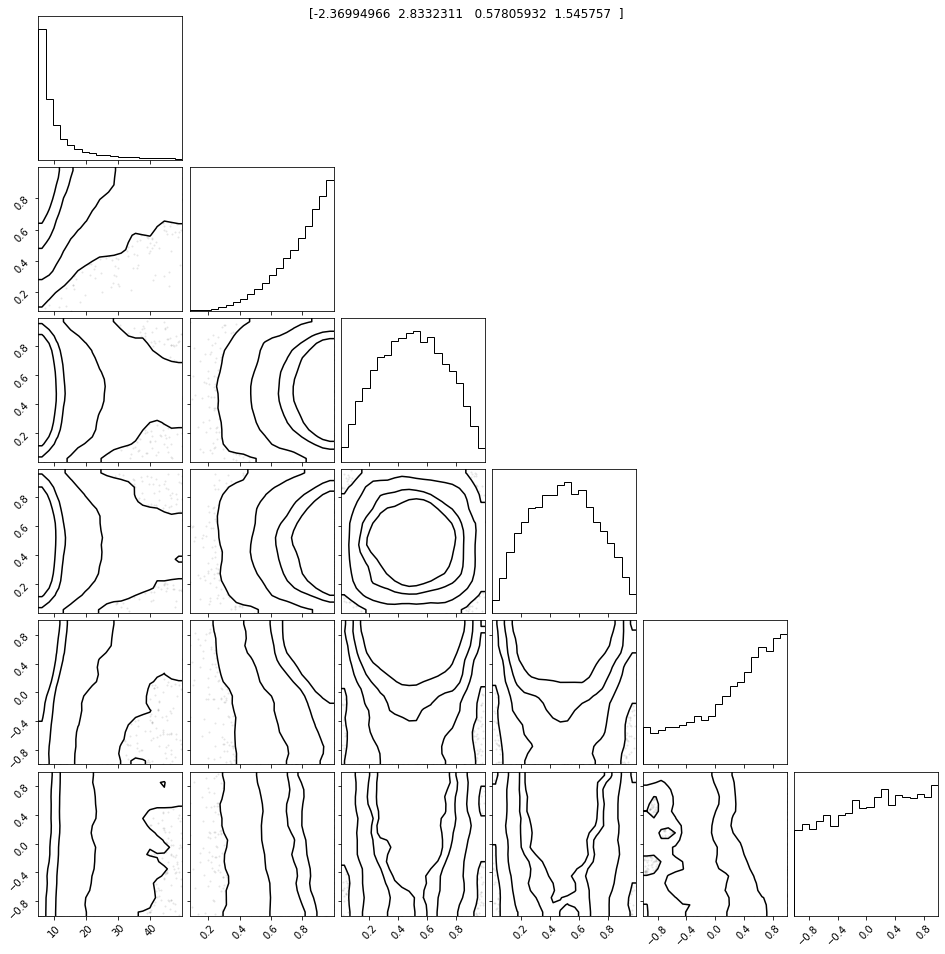

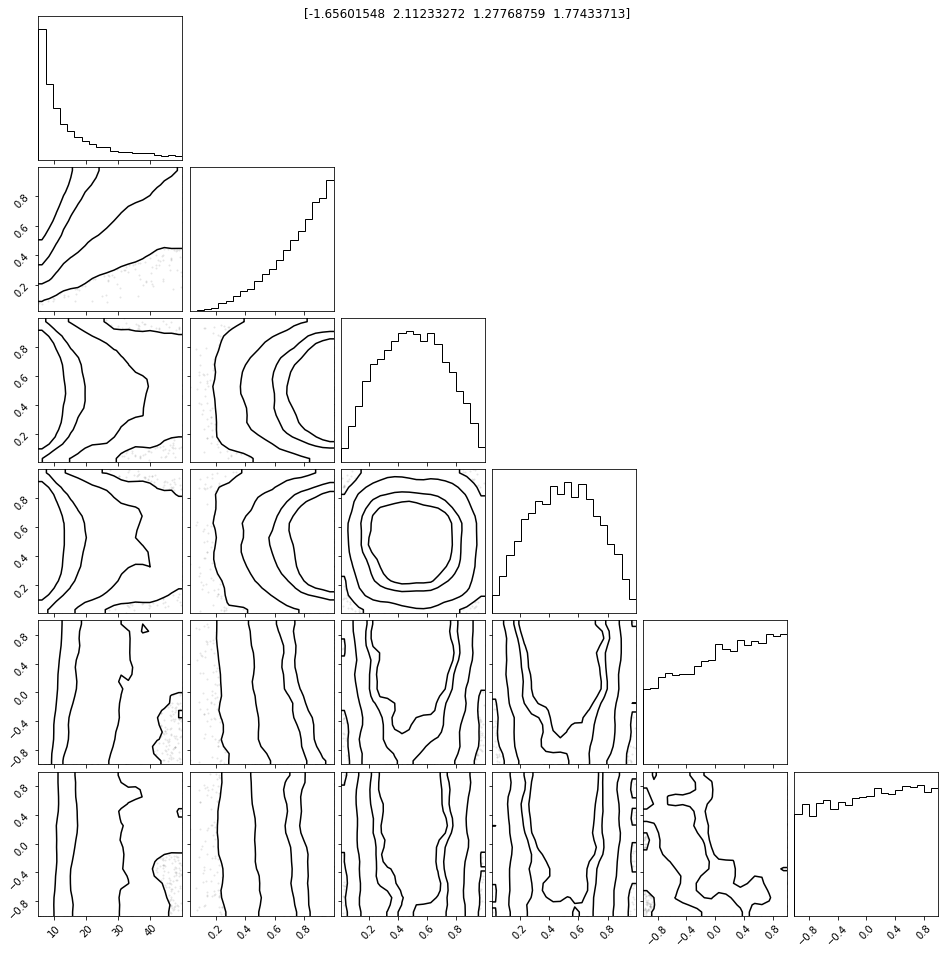

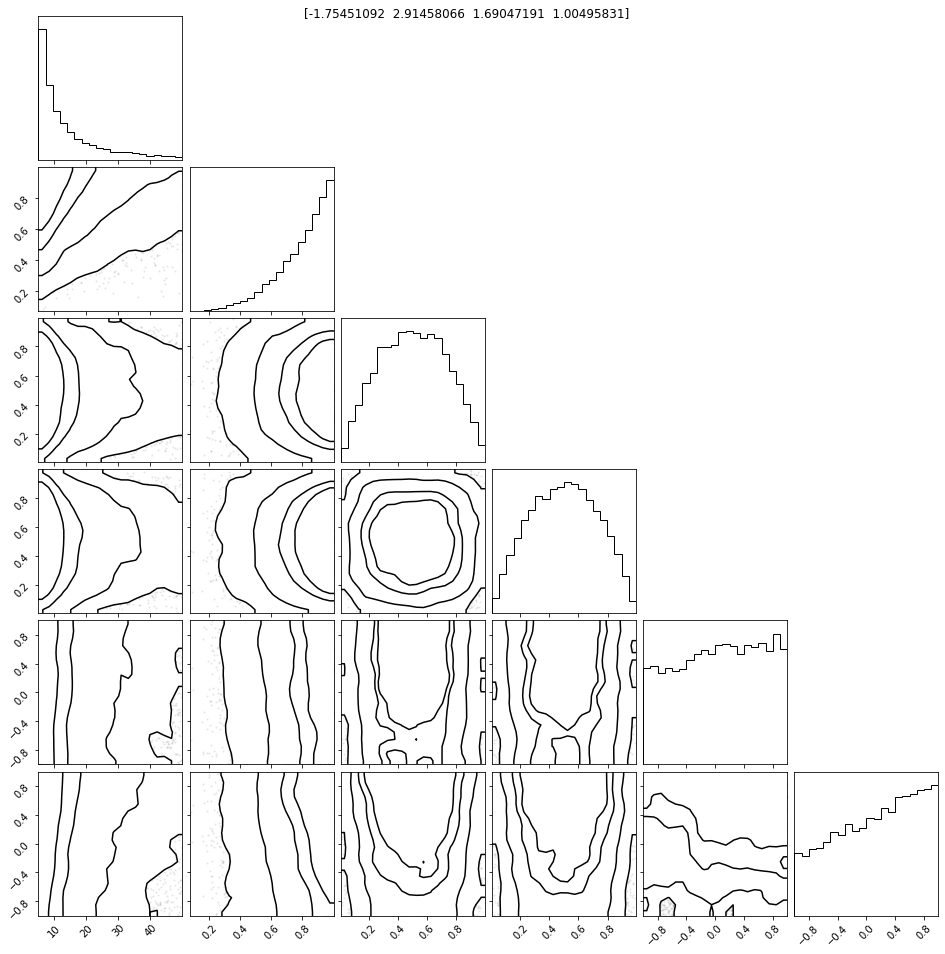

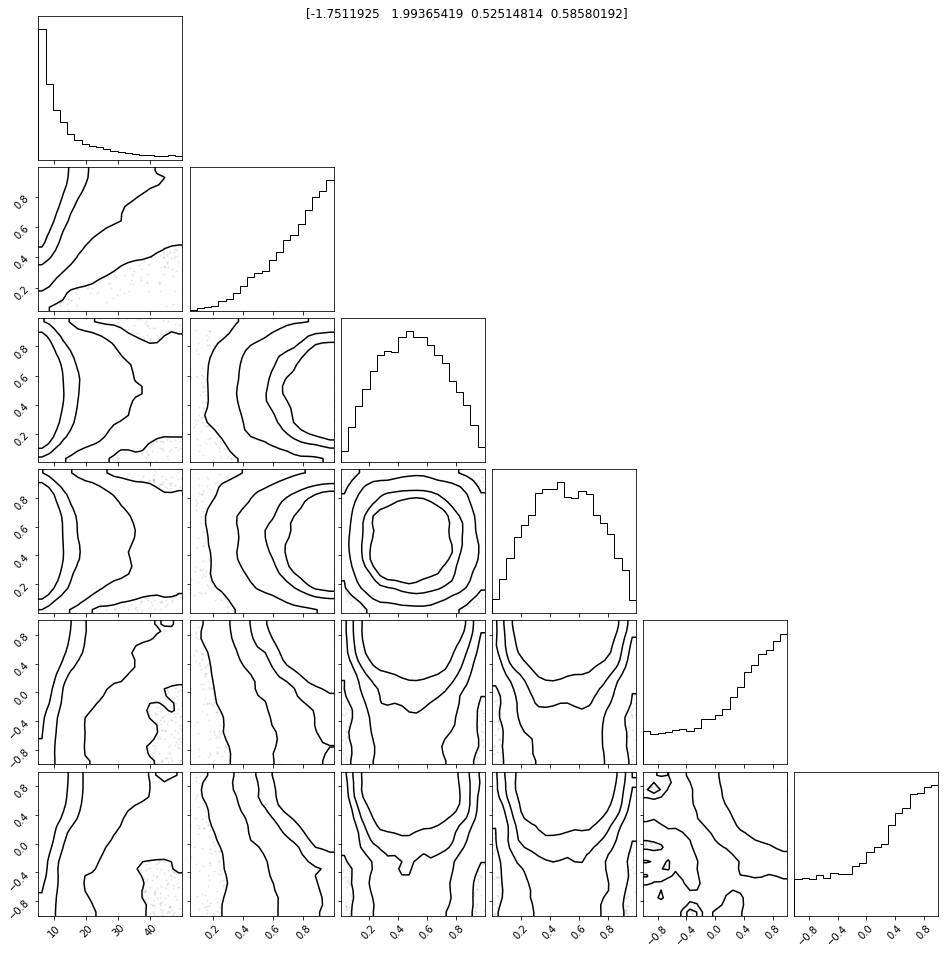

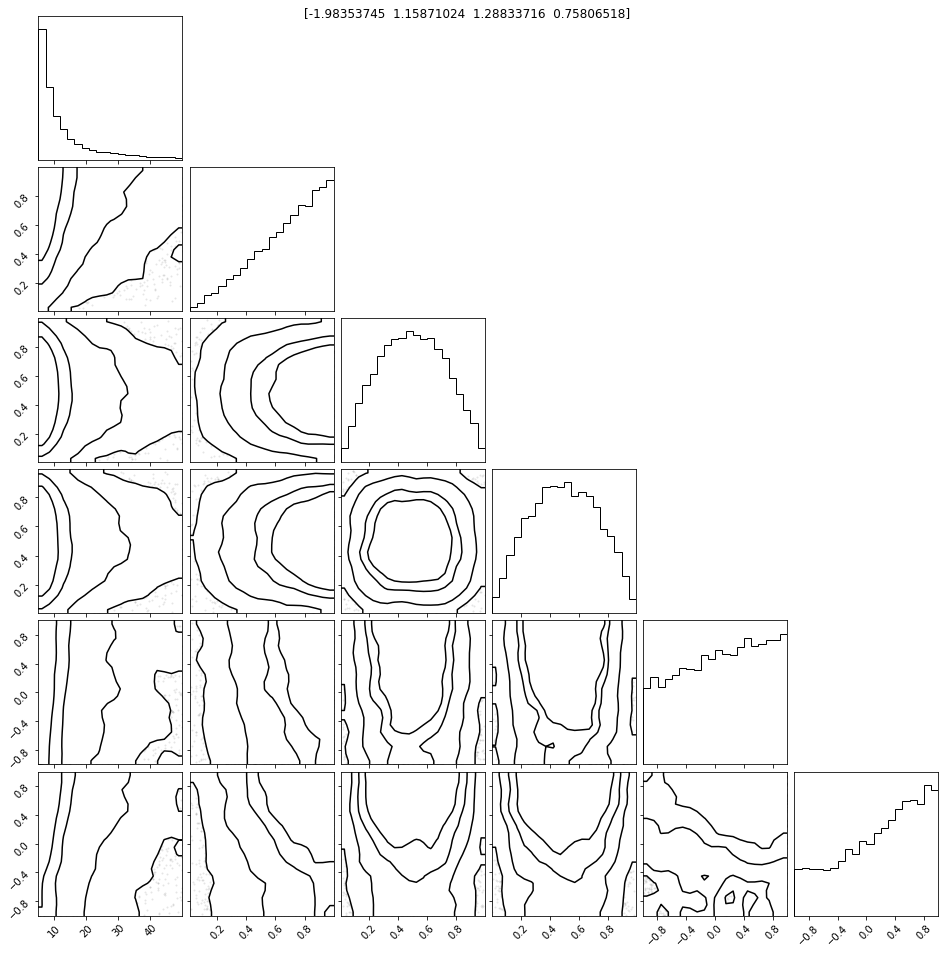

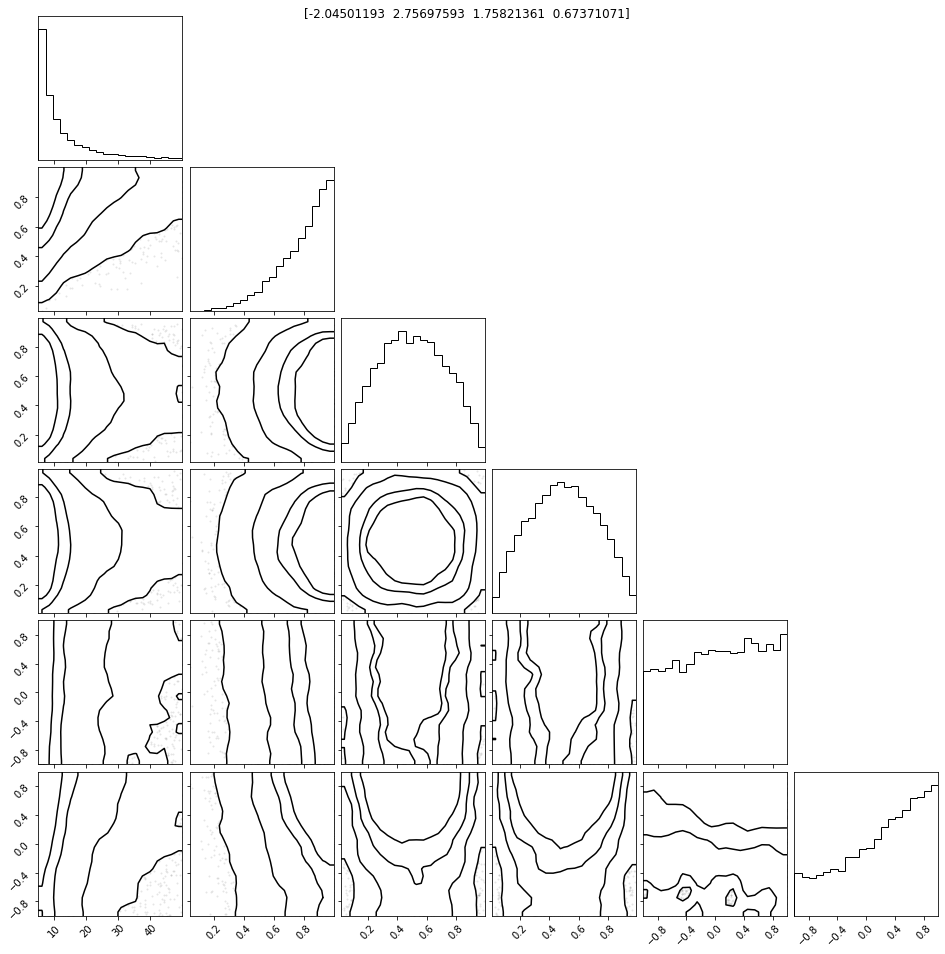

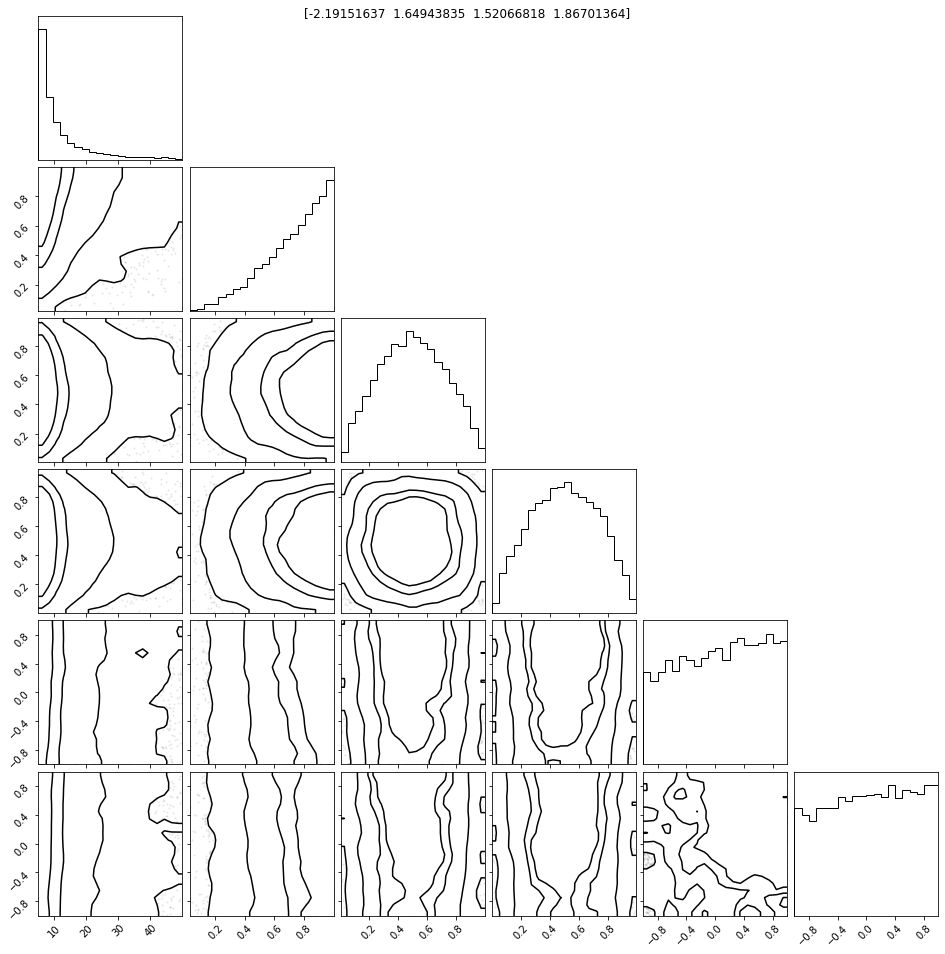

In [40]:
for par, sample in zip(pars, samples):
    fig = corner(
        sample,
        plot_data_points=False, plot_density=False,
        levels=[.5, .68, .9, .99], smooth=1,
        )
    fig.suptitle(par)